# Detailed Exploratory Data Analysis, Feature Engineering and Selection


The present work serves as a guide to various nuances involved with house prices datasets which often get overlooked which i aim to guide you through with the help of detailed Exploratory data analysis, we will also look at various feature engineering possibilities and perform extensive feature selection on the basis of results from the Exploratory data analysis. Following are the few aspects we have covered in the work below:


* Finding multicollinearity between various features.

* Finding features with lack of information.

* Trap of the ordinal features!! which should not actually be considered as ordinal feature, given they are ordinal.

* Comnining labels for various categorical features to reduce the dimensionality of the feature while enhancing the feature itself.

* Finding few nasty outliers which haunt a number of continuous features!!


Finally in the feature engineering phase we will create new features on the basis of the knowledge gained in the EDA section and we will finally try to extract a feature interaction with correlation with the target better than any other feature we have!!

Lets get started!!

In [ ]:
!pip install seaborn==0.11.0 # upgrading seaborn library to use newer plots and features!!

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import probplot, skew
from scipy.special import boxcox1p


from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

pd.options.display.max_rows =300

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

In [ ]:
# define all the palettes
palette_1 = sns.color_palette('Set1')
palette_2 = sns.color_palette('Paired', 10)
palette_3 = sns.color_palette('PuOr', 10)
palette_4 = sns.color_palette('Pastel1', 10)
palette_5 = sns.color_palette('Accent', 10)
palette_6 = sns.color_palette('Set3')

In [ ]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

First of all to make the dataset look a little bit less overwhelming, we have separated it out into numerical and categorical features, categorical features can be further divided into ordinal and one hot features... we will look into that later, but for now doing this helps us easily perform EDA on these two types of feature effectively as both these categories require there own EDA approach...
* in case of Categorical features we will be concerened more about features lacking info i.e features which have majority of only one type of label.... features that can be combined together... features that can be further simplified 

* in case of Numerical features we will be concerened with checking the skewness, outliers etc.

In [ ]:
categorical_features = ['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 
                        'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 
                        'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
                        'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 
                        'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 
                        'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 
                        'Heating', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 
                        'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 
                        'MasVnrType', 'MiscFeature', 'Neighborhood', 'OverallCond', 
                        'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
                        'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'HouseStyle']


numerical_features = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 
                      'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 
                      'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 
                      'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']

temporal_features = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold', 'GarageYrBlt']

Lets first of all plot the missing values!!

In [ ]:
sns.set_style('darkgrid')

def null_vals(train, test): 
    plt.figure(figsize=(16, 17))
    for i, df in enumerate([train, test]):

        df = df.isna().sum().to_frame()
        df = df[df.iloc[:, 0] != 0]
        df.rename({0:'Null Count'}, axis=1, inplace=True)
        df['% Null'] = (df['Null Count'] / len(train)) * 100
        df = df.sort_values(by='Null Count').reset_index()
        plt.subplot(2, 1, i + 1)
        plt.subplots_adjust(hspace=.4)
        color = sns.color_palette('YlOrRd', 20) if len(df) < 20 else sns.color_palette('YlOrRd', 37)
        sns.barplot(data = df, x='index', y='Null Count', palette=color)
        plt.tick_params(axis='both', labelsize=10)
        plt.tick_params(axis='x', labelrotation=90)
        title = 'Training data' if i == 0 else 'Testing data'
        plt.title(title, fontsize=35, loc='Left', y=1.05)
        plt.xlabel('Feature', fontsize=15)
        plt.ylabel('Null Count', fontsize=15)  
        
        
null_vals(train, test)

Looking at the above distributions of missing values, its quite clear some features have just too many missing values, so we will exclude them from further analysis

In [ ]:
def missing_val_imputer(df):
    
    # lets just drop them first
    df.drop(['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'], axis=1, inplace=True)
    
    # Garage Type feature have Nan values which mean No garage!
    for feature in df.columns :
        if feature in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
            df[feature].where(~df[feature].isna(), 'No Garage', inplace=True)
            
        elif feature in ['GarageYrBlt']:
            
            mean_vals = df.groupby('Neighborhood')[feature].transform('median')
            df[feature].fillna(mean_vals, inplace=True)
            
    # Features related to Basement have missing value if there is no basement
    for feature in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[feature].where(~df[feature].isna(), 'No Basement', inplace=True)
        
    # few instances do not have Masonary Veener, so they have Nan in those places    
    df.MasVnrType.where(~df.MasVnrType.isna(), 'Not present', inplace=True)
    df.MasVnrArea.where(~df.MasVnrArea.isna(), 0, inplace=True)
    
    # Lets groupby Neighborhood and fill LotFrontage
    
    mean_vals = df.groupby('Neighborhood')['LotFrontage'].transform('mean')
    df['LotFrontage'].fillna(mean_vals, inplace=True)
    
    # lets fill all the remaining values with most frequent values if feature is categroical and mean if feature is numerical
    for feature in df.columns:
        if feature in numerical_features:
            mean_val = df[feature].mean()
            df[feature].fillna(mean_val, inplace=True)

        elif feature in categorical_features:
            most_frequent_val = df[feature].mode()[0]
            df[feature].fillna(most_frequent_val, inplace=True)

        elif feature in temporal_features:
            most_frequent_val = df[feature].mode()[0]
            df[feature].fillna(most_frequent_val, inplace=True)
    
    return df

In [ ]:
train_imputed = missing_val_imputer(train.copy())
test_imputed = missing_val_imputer(test.copy())

# 1. Correlation Check


As we are working on a regression problem, finding what is correlation between variables and correlation of those with the target is extremely important to check because:
* First, we can see which features are awfully correlated to each other, these feature introduce multicollinearity within the dataset which introduces redundancy within the dataset.

* Second, we get to know correlation of features with target variables which can help us drop features which are not at all correlated and will only act as noise.

Heat map is one of the best if not the best way to visualize the correlation, i suggest using cmap = 'coolwarm' as it makes easy to observe the highly correlated regions with colors that are not to hard on the eyes.

In [ ]:
# Correlation check 

corr_df = train_imputed.iloc[:, 1:].corr().round(2) # rounding to 1 decimal point to make it easier to observe correlated features


plt.figure(figsize=(16, 14))
sns.heatmap(corr_df, cmap='coolwarm', annot=True, square=True, annot_kws=dict(size=10), cbar=True)
plt.show()

There are few things that attarct my attention:
* First, we can observe two red squares around (`TotalBsmtSF` and `1stFlrSF`) and around garage features, this shows high correlation between these features, we might have to drop some features here and pick the best one out. We also have correlation of about `0.8` between `GrlivArea` and `TotRmsAbvGrd`, `BedroomAbvGrd` and `TotRmsAbvGrd`,` YearBuilt` and `GarageYrBlt`.


* Second, `OverallQual`, `YearBuilt`, `YearRemodAdd`, `MasVnrArea`, `GrLivArea`, `FullBath`, `TotRmsAbvGrd`, `Fireplaces`, `GarageYrBlt`, `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF` are best correlated with the target, lets also check them out more closely.


* Third, Observe how at the bottom and right side of the heat map we just have a blue colored region, this is a good thing only if features contributing to this blue colored region were highly correlated to the Target, which is not the case, which tells us that there is no information present in these features, we will perform follow up analysis to check this inference.

# 2. Inspecting  various feature types

There are 4 types of features that i can broadly classify this dataset as,

* Categorical features:
  * Nominal Type : labels do not express implicit order
  * Ordinal Type : labels have an implicit order.
  

* Numerical / Continuous features


* Temporal features


## 2.1 Categorical features


### 2.1.1 Nominal features

At this stage we will plot the strip plots for all the categorical features so that we can:
* find out features that do not contain info


* features that might be more expressive if we somehow combine them or simplify them


* features that do ot have much target value variation across different categories... They are useless too if we cannot find any good correlation for that feature with other features as they do not have any pattern we can harness to improve predicitons.


We will be using strip plot with boxplot, you can also use swarm plot but it hides boxplots so we will be using strip plots... the idea is that these plots tell what is the distribution of instances in different categories, we will be easily able to visualize in which category the most of the instances are concentrated.

In [ ]:
# as we have dropped some features we have to update the categorical features list too

categorical_features = list(set(categorical_features) - set(['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']))

In [ ]:
fig, ax = plt.subplots(25, 2, figsize=(16, 130))
plt.subplots_adjust(hspace=0.3)


PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black', 'linewidth':0.3},
    'medianprops':{'color':'black', 'linewidth':1.5},
    'whiskerprops':{'color':'black', 'linewidth':0.3},
    'capprops':{'color':'black', 'linewidth':0.3},
} 



for i, feature in enumerate(categorical_features):
    colors = np.random.choice([palette_1, palette_2, palette_3])
    plt.subplot(25, 2, i+1)
    sns.boxplot(x=feature, data=train_imputed, y='SalePrice', showfliers=False,  **PROPS) # stage 2
    sns.stripplot(x=feature, data=train_imputed, y='SalePrice', palette=colors, linewidth=0.3)
    if train_imputed[feature].nunique() > 10:
        plt.tick_params(axis='x', labelsize=9, labelrotation=45)
    plt.xlabel(feature, fontsize=12) 
    plt.ylabel('SalePrice', fontsize=12) 


**Findings** : From the above plots we can infer a lot of important things, there are alot of features that only conatin mostly one type of label, a lot of feature that have to many missing values, features that do not have any similar mean target value across its various categories which is not a good thing as there is no differentiation possible within different categories... lets list all these findings feature wise. ***`No Garage` label that we imputed earlier is actually a pretty informative one, house with no garage are less expensive, which is quite intuitive!!*** 

**To drop**: There a lot of features that we can drop!! they just do not give any info gain or they have too many missing value or have similar target means.
* `BsmtFinType2`: most instances concentrated in `Unf`, plus the mean target value for labels in this feature is also not to informative as mean value for all the labels lie close to each other, its better to just concentrate on `BsmtFinType1`.


* `BsmtHalfBath`: too many instances in label `0` and mean target value is same for the labels, it does not provide any info whatsoever.


* `Condition2`: Almost all the instances lie in `Norm`, no info gain.


* `Electrical`: Quite a lot of instances are with label `SBrkr`, i do not think it will be as useful, i would rather not increase 3-4 one hot columns in my dataset by keeping it and increasing dimensionality and increase chances of overfitting.


* `Exterior2nd`: A copy of `Exterior1st` feature, cardinality is too high, lets just keep one of them


* `Functional`: Too many instances in the `Typ` label.


* `Heating`: Too many instances in the `GasA` label.


* `KitchenAbvGr`: Too many instances in the `1` label.


* `LandSlope`: Too many instances in the `Gtl` label and it seems to somewhat related to `LandContour` and `LotShape`.


* `RoofMatl`: almost all the instances have label `CompShg`, No information gain.
 

* `Street`: almost all the instances have label `Pave`, No information gain.


* `Utilities`: almost all the instances have label `AllPub`, No information gain.


* `RoofStyle` : not informative, two labels `Gable` and `Hip` have most of the instances and there spreads are quite equivalent


* `LotConfig` : the spread is equivalent and the means are around the same values

Now, it is not necessary to drop these features, an expert in the field related to houses can find really good relations betweem these features that are based on human inference based on experience and field expertise, but statistical tests such as `chi-square test` will not be able to unfold those hidden relations that only an expert can infer, so we will have to drop these features.

**Combine labels**: there are a lot of features that have labels that are somewhat similar in the sense that there mean target values are similar, so we can essentially say that if these labels are not related to some other labels in othe categorical features, if we combine them together into a single label, we will not be dropping any information, rather we will be decreasing the dimensionality and cardinality of our categorical labels and also reducing labels will very few instances present with them and combine these labels into a new label `other` with increased number of instances present with it. Again, an analysis to find out which labels are actually related to some other labels in other categorical variables will require a lot of in depth analysis, that is better down by a domain expert.


*benefit we get by doing so is that we combine labels with very few instances and similar target means which is a label quite similar to these labels with increased instances present for it, hence increasing its significance.*

First we have to convert MSSubClass to 'object' and then combine its labels

* `MSSubClass` : combine labels `20 + 75 + 70 + 80` to `label_1`, `40 + 50 + 85 + 90 + 190` to `label_2` and `45 + 30 + 180` to
`label_3`


* `Condition1` : combine labels `PosN + RRNn + PosA + RRNe + RRAn`  as `PPRRR` and `Feedr + Artery + RRAe` as `FAR`


* `BldgType`: combine labels `2fmCon`, `Duplex` and `Twnhs` to new label `other`.


* `BsmtFinType1`: combine labels ` ALQ`, `Rec`, `BLQ`, `LwQ`  into `other`.


* `Foundation`: combine labels `Wood`, `Slab` and `Stone` into `other`.


* `GarageType`: combine labels `Detchd`, `CarPort`, `Basment` and `2Types` into `other`.


* `LotShape`: combine labels `IR2` and `IR3` into `other`.


* `MasVnrType`: combine labels `None` and `BrkCmn` into `other`.


* `SaleCondition`: combine labels `AdjLand`, `Alloca`, `Family` and `Abnorml`


* `SaleType`: combine labels `COD`, `ConLD`, `ConLI`, `CwD`, `ConLw`, `Con` and `Oth` into `other`.


* `HouseStyle`: cobine labels `2Story + 2.5Fin` into `label_1`, `SFoyer + 1.5Fin` into `label_2`, `SLvl + 1Story` into `label_3` and `1.5Unf + 2.5Unf` into `label_4`.


* `PavedDrive`: combine labels `N` and `P` into `other`.


* `MSZoning`: combine `C (all)`, `RM` and `RH` into `other`.


* `Neighborhood` : combine `MeadowV + BrDale + IDOTRR` to`MBD`, `Sawyer + NAmes + NPkVill + Mitchel + SWISU + Blueste` to 
`SNNSBM`, `Gilbert + Blmngtn + SawyerW + NWAmes` to `SNGB`, `ClearCr + CollgCr + Crawfor` to `CCC`, `Veenker + Timber + 
Somerst` to `VTS`, `OldTown + Edwards + BrkSide` to `OBE`, `StoneBr + NridgHt + NoRidge` to `SNN`.

### 2.1.2 Ordinal features 


I feel this category deserves its own separate analysis too other than as above where we just combined it together with categorical type, i purposeful not include any oridnal features into analysis. Here we will explore.
* ***Trap of Ordinal features***: these features are supposed to encoded so that we assign increasing numeric values to categories higher in order, but doing so might create encoded feature not at all correlated with target as we will see.


* Ordianl features we should drop.

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(16, 25))
plt.subplots_adjust(hspace=0.3)


PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black', 'linewidth':0.3},
    'medianprops':{'color':'black', 'linewidth':1.5},
    'whiskerprops':{'color':'black', 'linewidth':0.3},
    'capprops':{'color':'black', 'linewidth':0.3},
} 

# we will only consider ordinal features which we have not dropped in above section and did not comvert to categorical type.
ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure','HeatingQC', 'KitchenQual',
                    'GarageFinish', 'GarageQual', 'GarageCond']

for i, feature in enumerate(ordinal_features):
    colors = np.random.choice([palette_1, palette_2, palette_3])
    plt.subplot(5, 2, i+1)
    sns.boxplot(x=feature, data=train_imputed, y='SalePrice', showfliers=False,  **PROPS) # stage 2
    sns.stripplot(x=feature, data=train_imputed, y='SalePrice', palette=colors, linewidth=0.3)
    if train_imputed[feature].nunique() > 10:
        plt.tick_params(axis='x', labelsize=9, labelrotation=45)
    plt.xlabel(feature, fontsize=12) 
    plt.ylabel('SalePrice', fontsize=12) 


**Findings**: From above plots it seems that we will have to drop some features and combine labels of few features.

**Trap alert**: As i have already mentioned, we encode ordinal features with increasing numeric value with increasing label value, for eg :- freezing, cold, warm, hot, lava hot to 1, 2, 3, 4, 5 and if the target is a continuous temperature than it is quite intuitive that our ordinal feature will be highly correlated with target. When we look at ordinal features in our dataset. Po(Poor), Fa(Fair), TA(Average), Gd(Good), Ex(Excellent) should follow 1, 2, 3, 4, 5 where they are highly correlated with the hosue price, if thats the case it makes things easy. But thats not the case for many ordinal features and main reason being lack of instances in some of these ordinal categories, So we will either combine labels to extract value or just drop such features. Lets check them out.

* `ExterCond` : Mean target value for Gd is below TA and Ex has too less instances so we do not know what its actual range should be, but all in all, moreover more than 87% instances are in TA, feature itself does not contribute much info, plus the fact that oridanly encoding it will just create a numeric feature not correlated with target makes things worse. So we will drop it.


* `GarageQual` : Again a feature that will not be correlated with target if encoded in ordinal fashion, it has almost 90 % instances in TA label, not much info.


* `GarageCond` : Same reason as above.


**Combine labels**: Now as we have discussed about the Trap, Not all ordinal features are like that, There are some really great features that will correlate very well with target if ordinally encoded!!

* `ExterQual` : Spreads are quite great!! They quite efficaciously capture the price ranges increase with label level increase. We can combine `Fa` and `TA` to `other`.


* `BsmtQual` : This feature is great a proper defination of ordinal feature!! just check out the spreads, they are highly correlated with target, by combining labels `No Basement` and `Fa` into `other`, we make these distintions even clearer. 


* `BsmtCond` : combine `No Basement`, `Fa` and `Po` into `other`.


* `BsmtExposure` : combine `Mn`, `Av` into `other`.


* `HeatingQC` : combine `Po`, `Fa`, `TA` into `other`.


* `KitchenQual` : combine `TA` and `Fa` into `other`.


* `GarageFinish` : combine `No Garage` and `Unf` into `other`.


***Now the only thing we have to know is whether it would be best to one hot encode the ordinal features or perform an ordinal encoding. We already have dropped a lot of cardinality one hot encoding might prove to be a better option!!***

In [ ]:
def label_combiner(df):
    df.MSSubClass = df.MSSubClass.astype(str)
    df.MSSubClass.replace({'20':'label_1', '75':'label_1', '80':'label_1', '70':'label_1', '40':'label_2', 
                           '50':'label_2', '85':'label_2', '90':'label_2', '190':'label_2',
                           '45':'label_3', '30':'label_3', '180':'label_3', '150':'label_2'}, inplace=True)
    
    df.ExterQual.replace({'Fa':'other', 'TA':'other'}, inplace=True)
    
    df.BsmtQual.replace({'No Basement':'other', 'Fa':'other'}, inplace=True)
    
    df.BsmtCond.replace({'No Basement':'other', 'Fa':'other', 'Po':'other'}, inplace=True)
    
    df.BsmtExposure.replace({'Mn':'other', 'Av':'other'}, inplace=True)
    
    df.HeatingQC.replace({'Po':'other', 'Fa':'other', 'TA':'other'}, inplace=True)
    
    df.KitchenQual.replace({'TA':'other', 'Fa':'other'}, inplace=True)
    
    df.GarageFinish.replace({'No Garage':'other', 'Unf':'other'}, inplace=True)
    
    df.Condition1.replace({'PosN':'PPRRR', 'RRNn':'PPRRR', 'PosA':'PPRRR', 'RRNe':'PPRRR', 
                           'RRAn':'PPRRR', 'Feedr':'FAR', 'Artery':'FAR', 'RRAe':'FAR'}, inplace=True)
    
    df.BldgType.replace({'2fmCon':'other', 'Duplex':'other', 'Twnhs':'other'}, inplace=True)
    
    df.BsmtFinType1.replace({'ALQ':'other', 'Rec':'other', 'BLQ':'other', 'LwQ':'other'}, inplace=True)
    
    df.Foundation.replace({'Wood':'other', 'Slab':'other', 'Stone':'other'}, inplace=True)
    
    df.GarageType.replace({'Detchd':'other', 'CarPort':'other', 'Basment':'other', '2Types':'other'}, inplace=True)
    
    df.LotShape.replace({'IR2':'other', 'IR3':'other'}, inplace=True)
    
    df.MasVnrType.replace({'None':'other', 'BrkCmn':'other', 'Not present':'Stone'}, inplace=True)
    
    df.SaleCondition.replace({'AdjLand':'other', 'Alloca':'other', 'Family':'other', 'Abnorml':'other'}, inplace=True)
    
    df.SaleType.replace({'COD':'other', 'ConLD':'other', 'ConLI':'other', 'CWD':'other', 'ConLw':'other', 'Con':'other'
                       , 'Oth':'other'}, inplace=True)
    
    df.HouseStyle.replace({'2Story':'label_1', '2.5Fin':'label_1', 'SFoyer':'label_2', '1.5Fin':'label_2', 'SLvl':'label_3', 
                          '1Story':'label_3', '1.5Unf':'label_4', '2.5Unf':'label_4'}, inplace=True)
    
    df.PavedDrive.replace({'N':'other', 'P':'other'}, inplace=True)
    
    df.MSZoning.replace({'C (all)':'other', 'RM':'other', 'RH':'other'}, inplace=True)
    
    df.Neighborhood.replace({'MeadowV':'MBD', 'BrDale':'MBD', 'IDOTRR':'MBD',
    'Sawyer':'SNNSBM', 'NAmes':'SNNSBM', 'NPkVill':'SNNSBM', 'Mitchel':'SNNSBM', 'SWISU':'SNNSBM', 'Blueste':'SNNSBM', 
    'Gilbert':'SNGB', 'Blmngtn':'SNGB', 'SawyerW':'SNGB', 'NWAmes':'SNGB',
    'ClearCr':'CCC', 'CollgCr':'CCC', 'Crawfor':'CCC',
    'Veenker':'VTS', 'Timber':'VTS', 'Somerst':'VTS',
    'OldTown':'OBE', 'Edwards':'OBE', 'BrkSide':'OBE',
    'StoneBr':'SNN', 'NridgHt':'SNN', 'NoRidge':'SNN'}, inplace=True)
    
    return df

In [ ]:
train_imputed = label_combiner(train_imputed.copy())
test_imputed = label_combiner(test_imputed.copy())

Lets Look at the new distributions of the categorical variables!!

In [ ]:
fig, ax = plt.subplots(11, 2, figsize=(16, 70))
plt.subplots_adjust(hspace=0.3)


PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black', 'linewidth':0.3},
    'medianprops':{'color':'black', 'linewidth':1.5},
    'whiskerprops':{'color':'black', 'linewidth':0.3},
    'capprops':{'color':'black', 'linewidth':0.3},
}



for i, feature in enumerate(['MSSubClass', 'Condition1', 'BldgType', 'BsmtFinType1', 'Foundation', 'GarageType', 'LotShape', 
                             'MasVnrType','SaleCondition', 'SaleType', 'HouseStyle', 'PavedDrive', 'MSZoning', 'Neighborhood',
                             'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure','HeatingQC', 'KitchenQual',
                             'GarageFinish']):
    colors = np.random.choice([palette_1, palette_2, palette_3])
    plt.subplot(11, 2, i+1)
    sns.boxplot(x=feature, data=train_imputed, y='SalePrice', showfliers=False,  **PROPS) # stage 2
    sns.stripplot(x=feature, data=train_imputed, y='SalePrice', palette=colors, linewidth=0.3)
    if train_imputed[feature].nunique() > 10:
        plt.tick_params(axis='x', labelsize=9, labelrotation=45)
    plt.xlabel(feature, fontsize=12) 
    plt.ylabel('SalePrice', fontsize=12)

Looks great!!! The spreads are dense, have unique means and the cardinality is has been reduced by a lot!!! these dense categories will make it easier for our model to learn which price range is more probable in which label, which was not so obvious with so many labels with so few instances for our model to train on in a number of labels while most of instances were in just a single label.

In [ ]:
to_drop = ['ExterCond', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtHalfBath', 'Condition2','Electrical',
           'Exterior2nd', 'Exterior1st', 'Functional', 'Heating','KitchenAbvGr','LandSlope','RoofMatl','Street','Utilities',
           'RoofStyle','LotConfig']

## 2.2 Numerical features

Lets check out numerical features with scatter plots 

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(16, 40))
ax = ax.reshape(-1, )
cmap_1 = sns.cubehelix_palette(start=0, rot=-0.4, gamma=0.9, hue=1.0, light=0.8, dark=0, as_cmap=True)
outlier_index = []

for i, feature in enumerate(numerical_features): 
    sns.scatterplot(data=train_imputed, x=feature, y='SalePrice',  hue='SalePrice', palette=cmap_1, ax=ax[i])
    if feature in ['1stFlrSF', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage',
                   'TotalBsmtSF', 'WoodDeckSF', 'OpenPorchSF']: 
        
        # lets point out some outliers
        max_val = train_imputed[feature].quantile(q=.995)
        min_price = 400000
        
        outliers = train.loc[((train_imputed[feature] > max_val) & (train_imputed.SalePrice < min_price))][[feature, 'SalePrice']]
        outlier_index.extend(list(outliers.index))
        ax[i].plot(outliers[feature], outliers['SalePrice'], 'ro', )
        ax[i].plot([max_val, max_val], [0, 750000], 'r--')
        
sns.set_style('darkgrid')    
sns.despine()

In [ ]:
outlier_series = pd.Series(outlier_index)
outlier_series.value_counts() # we will pick out outliers that are common to many features

Not all the data points we represented as outliers above need to be classified as one, because they exist as outlier in only one feature, but we some bad boys!! ***1298*** and ***523*** are haunting so many features, worse part is that they are actually prettey bad and follow totaly opposite trend compared to other data points in the feature, these are the two right most and bottom most 2 outliers in `GrLivArea`, `1stFlrSF`, `BsmtFinSF1` and `TotalBsmtSF`. we have to drop them!!!

In [ ]:
outlier_list =  list(outlier_series.value_counts().iloc[:5].index)
outlier_list

**Findings**: From the above plots we were able to deduce lots of info,

* We have a lot of `Heteroscedasticity` in our features!! we will be dealing with it in a bit.


* There are a lot of outliers which make our data non informative, model will get confused because of them, as they go against the general trend of increase in `SalePrice` with increase in variable. for example look at 1stFlrSF where we have a outlier with feature value more than 4000 but price is around 200000, such outliers are more deterimental to our model than the normal ones which are just shooting beyond the 1.5 X quantile mark!!


* we can also see that there a lot of features that do not show any correlation with the target, we might drop them.

**Feature Engineering proposal**: 
* Combine `ScreenPorch`, `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch` into `TotalPorch` and drop them after analyzing the correlation with target and within themselves.

**Features to drop**:
* Drop `PoolArea` - No information gain.


* Drop `MiscVal` - No information gain.


* Drop `LowQualFinSF` - No information gain.


* Drop `BsmtFinSF2` - There is no correlation with the target, harnessing this feature to actually prove useful will require a lot of effort if it is even possible.

In [ ]:
to_drop.extend(['ScreenPorch', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 'MiscVal', 'LowQualFinSF', 'BsmtFinSF2'])

## 2.3 Temporal features 

I separated out temporal features as its own category because sometimes these features require there own visualization and preprocessing, as you can convert the feature in datatime type and perform time series analysis. lets just visualize the feature

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(15, 30)) 
plt.subplots_adjust(hspace=.25)


cmap_2 = sns.cubehelix_palette(rot=.5, dark=0.25, light=0.8, as_cmap=True)

for i, feature in enumerate(temporal_features):
    feature_series = train_imputed.groupby(feature).SalePrice.mean()
    
    sns.scatterplot(data=train_imputed, x=feature, y='SalePrice',  hue='SalePrice', palette=cmap_2, ax=ax[i], zorder=1)
    #sns.pointplot(data=train, x=feature, y='SalePrice', linestyles='--'
                  #errwidth=.7, scale=0.4, color='k', markers='x', ax=ax[i], zorder=2)
    ax[i].plot(feature_series, '^k--', markersize=3, linewidth=1)
    ax[i].set_xlabel(f'{feature}', fontsize=15, labelpad=10)
    ax[i].set_ylabel('SalePrice', fontsize=15, labelpad=10)

    
    
sns.set_style('darkgrid')
plt.show()

**Findings**: feature `MoSold` and `YrSold` are too stable, they do not show any trend which can be harnessed by the model to make better predictions as there is differentiating factor, unless we can do some in depth time series analysis, we might not be able to utilize these feature hence we have to drop them.
* To drop : `MoSold` and `YrSold`

In [ ]:
to_drop.extend(['MoSold', 'YrSold'])

# 3. Feature Engineering

## 3.1. Removing Outliers


At this stage will be exploring the outliers we identified in the previous section and visualize there positions in various continuous features and remove those outliers that are affecting most of the features.

In [ ]:
outlier_list

These are the list of outliers that we have found to be recurrent within the continuous features with good correlation with the target, these outliers have the following tendency:
* These are outliers which have lower `SalePrice` with high variable value. 
* these outliers are deterimental given the fact that they introduce opposite trend than the overall trend of the variable with the target.

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(16, 23)) # stage2 , stage 1 should just have a single plot
ax = ax.flatten()


for i, feature in enumerate(['1stFlrSF', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage',
                   'TotalBsmtSF', 'WoodDeckSF']):
    sns.scatterplot(data=train_imputed, x=feature, y='SalePrice', hue='SalePrice', 
                    palette=sns.cubehelix_palette(start=0.5, rot=-1, gamma=1.3, hue=1, light=0.83, dark=0.1, as_cmap=True), 
                    ax=ax[i])
    sns.scatterplot(data=train_imputed.iloc[[1298, 523]], x=feature, y='SalePrice', color='red', marker='o', ax=ax[i])

We can see that not all the outliers make sense for all the features, some are not even close to being outliers for some features, we shall check dropping how many outliers does the trick, from 8 - 2, we will be dropping 1298 and 523 for sure. 

## 3.2. Simplifying categorical features


We have already seen the whole process, lets compare Neighborhood feature before and after and appreciate the changes

In [ ]:
temp = train.copy()

temp['Neighborhood_mod'] = temp.Neighborhood.replace({
    # MBD label
    'MeadowV':'MBD', 'BrDale':'MBD', 'IDOTRR':'MBD',
    
    # SNNSBM label
    'Sawyer':'SNNSBM', 'NAmes':'SNNSBM', 'NPkVill':'SNNSBM', 'Mitchel':'SNNSBM', 'SWISU':'SNNSBM', 'Blueste':'SNNSBM', 
    
    # SNGB label
    'Gilbert':'SNGB', 'Blmngtn':'SNGB', 'SawyerW':'SNGB', 'NWAmes':'SNGB',
    
    # CCC label
    'ClearCr':'CCC', 'CollgCr':'CCC', 'Crawfor':'CCC',
    
    # VTS label
    'Veenker':'VTS', 'Timber':'VTS', 'Somerst':'VTS',
    
    # OBE label
    'OldTown':'OBE', 'Edwards':'OBE', 'BrkSide':'OBE',
    
    # SNN label
    'StoneBr':'SNN', 'NridgHt':'SNN', 'NoRidge':'SNN'})
sns.set(font_scale=1)
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=.3)

for i, feature in enumerate(['Neighborhood', 'Neighborhood_mod']):
    colors = np.random.choice([palette_1, palette_2, palette_3])
    plt.subplot(2, 1, i+1)
    sns.boxplot(x=feature, data=temp, y='SalePrice', showfliers=False,  **PROPS) 
    if temp[feature].nunique() > 10:
        plt.xticks(rotation=45)
    sns.stripplot(x=feature, data=temp, y='SalePrice', palette=colors, linewidth=0.3)
    plt.xlabel(feature, fontsize=17, labelpad=10) 
    plt.ylabel('SalePrice', fontsize=17, labelpad=10) 

**Findings**: The spreads are quite concentrated in there own range of prices, we have effectively reduced the cardinality while retaining the info of target mean which each label had by a representative label!!
* Model will have more instances to train on where it would know that `SNN` label houses are priced more than the `MBD` labeled houses!!!


* The one hot columns we create will be way less than what we were create before, hence our model will have less tendency to overfit.

## 3.3. Feature creation through logical union of features

### 3.3.1 Temporal features engineering

In [ ]:
temporal_df = pd.concat([train_imputed[temporal_features], train_imputed['SalePrice']], axis=1)
temporal_df

In [ ]:
temporal_df['years_remod_after_built'] = temporal_df['YearRemodAdd'] - temporal_df['YearBuilt']
temporal_df['years_since_remod'] = 2021 - temporal_df['YearRemodAdd']
sns.heatmap(temporal_df.corr(), cmap='coolwarm', annot=True, annot_kws={'size':12})
plt.show()

**Findings**: The newely created features are highly correlated with `YearBuilt` and `YearRemodAdd`, so they are not as useful, other things is that we will have to drop `GarageYrBlt` as it is highly correlated with the`YearBuilt` feature.

### 3.3.2 TotalPorch

In [ ]:
temp = train_imputed.copy()
temp['TotalPorch'] = temp.loc[:, ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)

corr_df = temp.loc[:, ['TotalPorch', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice']].corr()
sns.heatmap(corr_df, cmap='coolwarm', annot=True)
plt.show()

**Findings**:
* `TotalPorch` feature is not a good feature when it comes to its correlation with the Target, we should just drop all porch features except `OpenPorchSF`.

### 3.3.3 TotalFlrSF

In [ ]:
temp = train_imputed.copy()
temp['TotalFlrSF'] = temp.loc[:, ['1stFlrSF', '2ndFlrSF']].sum(axis=1)

corr_df = temp.loc[:, ['TotalFlrSF', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'SalePrice']].corr()
sns.heatmap(corr_df, cmap='coolwarm', annot=True)
plt.show()

This is a great feature!! not only does it improves collinearity with target by adding `1stFlrSF` and `2ndFlrSF`, but it also solves the problem of multicollinearity of `1stFlrSF` with `TotalBsmtSF`, we can just drop `1stFlrSF` and `2ndFlrSF` while keeping the new feature `TotalFlrSF`. 

## 3.4 Creating feature through feature interactions


Feature interaction is basically observed when 2 or more than 2 variables are combined together by multiplying them with each other. 

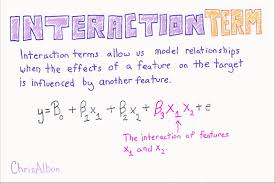


To create feature interaction between our various continuous features we first have to decide what is the maximum degree of interaction features can be, then class PolynomialFeatures() can then combine all the given features with every combination possible upto degree 3, it might be the case that some of the features may have correlation with target that is even greater than the features we currently have with us, but these interaction features will be correlated to the features it was based upon, But it is not always the case that interaction feature is correlated to  the interacting features, given the fact that there existed some hidden relation between these features which was expressed when these features were combined and overpowered the feature interaction actually become independent of the interacting feature, But we were not that lucky `:(` !! 

* we will be creating a super feature out of the best correlated features we have.

* then we will create an interaction feature out of those features which are not correlated well with the Target and try obtaining a feature which is a little better correlated and then drop the interacting features.

In [ ]:
class FeatureInteractionCorrelation(BaseEstimator, TransformerMixin):
    def __init__(self, *, interacting_features, degree=3, test=False):
        self.interacting_features = interacting_features
        self.degree = degree
        self.test = test
        self.fi = None
        self.interaction_feature_names = []

    def fit(self, X, y=None):
        
        self.fi = PolynomialFeatures(degree=self.degree, interaction_only=True, include_bias=False)
        self.fi.fit(X[self.interacting_features])
        
        return self
    
    def transform(self, X, y=None):
        feature_interaction_ndarray = self.fi.transform(X[self.interacting_features])
        
        if not self.test:
            # if training set, we will be returning correlation dataframe, but if test=True we will pass out the best correlated
            # features dataframe
            
            self.interaction_feature_names = [f'feature_{i}' for i in range(0, feature_interaction_ndarray.shape[1])]
        
            feature_interaction_df = pd.DataFrame(feature_interaction_ndarray, columns=self.interaction_feature_names, index=X.index)

            total_df = pd.concat([feature_interaction_df, X[self.interacting_features + ['SalePrice']]], axis=1)

            total_corr_df = total_df.corr()
        
            return total_corr_df, total_df
        
        else:
            feature_interaction_df = pd.DataFrame(feature_interaction_ndarray, columns=self.interaction_feature_names, index=X.index)
            best_features_df = feature_interaction_df.loc[:, self.best_correlations_list]
            
            return best_features_df
            
    
    def best_correlations(self, corr_df, corr_mean=0.3, min_corr=0.7):
        '''
        This methods returns the best correlations, returns a DataFrame with feature names as index, mean correlation with 
        all interacting features and correlation with SalePrice as columns
        
        corr_df : correlation dataframe
        
        corr_mean : pass the acceptable max value of mean correlation of interacting feature with all iteracting features. 
        
        min_corr : Minimum correlation required with the Target for the interaction feature to be acceptable.
        
        '''
      
        self.best_correlations_list = []
        for feature in self.interaction_feature_names:
            saleprice_corr = corr_df.loc[feature, 'SalePrice']
            interaction_feature_corr_mean = corr_df.loc[feature, self.interacting_features].sum() / len(self.interacting_features)
            if saleprice_corr > min_corr and interaction_feature_corr_mean < corr_mean:
                self.best_correlations_list.append(feature)

        df = corr_df.loc[self.best_correlations_list]
        df['SalePrice_correlation'] = df['SalePrice']
        df['Mean_interacting_features_corr'] = df[self.interacting_features].sum(axis=1) / len(self.interacting_features)
        df.drop(self.interaction_feature_names + self.interacting_features + ['SalePrice'], axis=1, inplace=True)

        return df

### 3.4.1 creating a highly correlated feature

In [ ]:
features_for_interaction = ['1stFlrSF','2ndFlrSF','3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 
                            'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea','MiscVal',
                            'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF','GarageCars', 'OverallQual', 
                            'FullBath', 'BsmtFullBath', 'Fireplaces', 'OverallCond', 'TotRmsAbvGrd', 'BedroomAbvGr', 'HalfBath']

In [ ]:
obj = FeatureInteractionCorrelation(interacting_features=features_for_interaction, degree=3, test=False)

In [ ]:
corr_df, total_df = obj.fit_transform(train_imputed)

In [ ]:
obj.best_correlations(corr_df, corr_mean=0.4, min_corr=0.8)

In [ ]:
x = list(obj.best_correlations(corr_df, corr_mean=0.4, min_corr=0.8).index)
df = pd.concat([total_df[x], train_imputed[features_for_interaction + ['SalePrice']]], axis=1)
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='coolwarm', annot_kws={'size':9}, fmt='.2g', square=True)
plt.show()

`feature_2677` looks awesome, lets visualize it by comparing its correlation with some of our great features

In [ ]:
temp = train_imputed.copy()
temp['feature_2677'] = total_df['feature_2677']

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
ax = ax.flatten()

for i, feature in enumerate(['feature_2677', 'GrLivArea', 'OverallQual', 'TotalBsmtSF']):
    sns.scatterplot(data=temp, x=feature, y='SalePrice', ax=ax[i])
    sns.scatterplot(data=temp.iloc[[1298, 523]], x=feature, y='SalePrice', color='red', ax=ax[i], marker='X', s=60)

Our new feature looks awesome!! it already shows no signs of heteroscedasticity and has excellent collinearity with the Target... But this feature comes with a cost, which is the multicollinearity it has horribly introduced within our dataset... we will have to see which features to drop and which to keep, But seeing that it was derived of features which had collinearity in the range 0.55 - 0.78, to get a 0.87 collinearity feature is quite a treat!!

You can notice those nasty 1298 and 523 outliers at the bottom of our ***`feature_2677`***!! They really are troubling our best features!

Now lets squeeze out best we can from Porch area features and many other less correlated features which we plan to drop. Best correlation these features have is around just 0.35, lets see if we can push it to 0.45 - 0.5 and then drop all the highly correlated features.

### 3.4.2 creating interaction feature from feature less correlated with target

Now lets first of all make list out of all the features which are not to great in terms of correlation wth target.

In [ ]:
low_correlation_features = ['2ndFlrSF', '3SsnPorch', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch','LotArea', 
                     'LotFrontage', 'LowQualFinSF','OpenPorchSF', 'ScreenPorch',
                     'WoodDeckSF', 'MoSold', 'YrSold']

In [ ]:
obj = FeatureInteractionCorrelation(interacting_features=low_correlation_features, degree=3)

In [ ]:
corr_df, total_df = obj.fit_transform(train_imputed.copy())

In [ ]:
obj.best_correlations(corr_df, corr_mean=0.15, min_corr=0.38)

In [ ]:
x = list(obj.best_correlations(corr_df, corr_mean=0.15, min_corr=0.38).index)
df = pd.concat([total_df[x], train_imputed[low_correlation_features + ['SalePrice']]], axis=1)
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='coolwarm', annot_kws={'size':9}, fmt='.2g', square=True)
plt.show()

lets take out `feature_275`, it looks good as per correlations with features which created it, and also it is not the most correlated with target than any othe features present on the heatmap, best ones are horribly correlated to `2ndFlrSF`, best part is we are dropping many features using which it was created.

# Final Data set creation

There few things i wish to check before we finalise our dataset which we will be using to train the model.

* Should we one hot encode or ordinal encode the ordinal features?


* should we drop the 'maybe_drop' list? 

To get this done we will be making a class which helps us grid search this as a hyperparameter that we can set through a pipeline.

Lets first lets create ordinal encoding of ordinal features which we can drop through the FeatureSelection class.

In [ ]:
def feature_creator(df):
    
    df['ExterQual_ord'] = df.ExterQual.replace({'other':1, 'Gd':2, 'Ex':3})

    df['BsmtQual_ord'] = df.BsmtQual.replace({'other':1, 'TA':2, 'Gd':3, 'Ex':4})

    df['BsmtCond_ord'] = df.BsmtCond.replace({'other':1, 'TA':2, 'Gd':3})

    df['BsmtExposure_ord'] = df.BsmtExposure.replace({'No Basement':1, 'No':2, 'other':3, 'Gd':4})

    df['HeatingQC_ord'] = df.HeatingQC.replace({'other':1, 'Gd':2, 'Ex':3})

    df['KitchenQual_ord'] = df.KitchenQual.replace({'other':1, 'Gd':2, 'Ex':3})

    df['GarageFinish_ord'] = df.GarageFinish.replace({'other':1, 'RFn':2, 'Fin':3})
    
    df['TotalFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    
    to_drop.extend(['1stFlrSF', '2ndFlrSF', 'Id'])
    
    df.drop(to_drop, axis=1, inplace=True)

    return df

train_imputed = feature_creator(train_imputed.copy())
test_imputed = feature_creator(test_imputed.copy())

In [ ]:
def boxcox(X):    
    cols = [feature for feature in X.columns if X[feature].dtype != 'O' and feature != 'SalePrice']

    for feature in cols:
        if (skew(X[feature]) < -0.5) or (skew(X[feature]) > 0.5):
            X[feature] = pd.Series(boxcox1p(X[feature], .3), index=X.index)
            
    return X

In [ ]:
train_imputed = boxcox(train_imputed)
test_imputed = boxcox(test_imputed)

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal=False, maybe_drop=True, drop_all_outliers=True, test=False):
        self.ordinal = ordinal
        self.maybe_drop = maybe_drop
        self.drop_all_outliers = drop_all_outliers
        self.test = test
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        if self.ordinal:
            X.drop(['ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                    'HeatingQC', 'KitchenQual', 'GarageFinish'], axis=1, inplace=True)
            
        else:
            X.drop(['ExterQual_ord', 'BsmtQual_ord', 'BsmtCond_ord', 'BsmtExposure_ord', 
                    'HeatingQC_ord', 'KitchenQual_ord', 'GarageFinish_ord'], axis=1, inplace=True)
      
        
        X = pd.get_dummies(X, drop_first=True)
        
        

        if self.maybe_drop:
            
            X.drop(maybe_drop, axis=1, inplace=True)
            
        #if self.drop_all_outliers:
            
            #X.drop(outlier_list, axis=0, inplace=True)
            
        #else:
            # have to drop these anyways.
            #X.drop([1298, 523], axis=0, inplace=True)
        
        cols = [feature for feature in X.columns if X[feature].nunique() != 2]
            
        if not self.test and len(X) > 500:
            self.scaler = StandardScaler()
            X[cols] = pd.DataFrame(self.scaler.fit_transform(X[cols]), columns=cols, index=X.index)
            
        else:
            X[cols] = pd.DataFrame(self.scaler.fit_transform(X[cols]), columns=cols, index=X.index)
            
        return X

In [ ]:
y_train = np.log1p(train_imputed.SalePrice)
X_train = train_imputed.drop('SalePrice', axis=1)

In [ ]:
param_grid = {'feature_selector__ordinal':[True, False],
              'feature_selector__maybe_drop':[True, False],
              'feature_selector__drop_all_outliers':[True, False]}

linreg = Pipeline([('feature_selector', FeatureSelector()),
                   ('linreg', Ridge())])

grid = GridSearchCV(linreg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid.fit(X_train, y_train)

In [ ]:
pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score']].nlargest(1, columns='mean_test_score')['params'].iloc[0]

### Conclusion

We have gone through a lot, following is a brief summary of what we have achieved:
* We found multicollinearity within our dataset.
* We pushed away high cardinality (i.e a lot of labels from our categorical variables) from our dataset by combining labels with some logically sound reasoning and EDA support.
* We proposed dropping a number of features on the basis of lack of information, missing values and more.
* We pointed out some bad ouliers and visualized there relative positioning in various features
* We created a number of features but also validated them, which showed they were not that great.
* Finally we created feature interactions which were more correlated with target than the interacting features!!

**if you liked the work, an upvote will be appreciated!!**
**if you have any suggestions or contructive criticism, please leave it in the comments!**